# **Akantu Tutorial : Fracture simulation with PhaseField**

The main goal of this tutorial is to model an edge crack propagation with phase field.

## **Import the necessary modules**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# import akantu
import akantu as aka
#import numpy for vector manipulation
import numpy as np
# import the pyplot submodule to draw figures
import matplotlib.pyplot as plt
# import triangluation routine to plot meshes
import matplotlib.tri as tri
# setting a default image size large enough
from plot_helper import *
from tqdm.notebook import tqdm
# all routines factored in a module
import tuto

In [2]:
params = {
'L': 32e-3,
'h1': 2.5e-4,
'h2': 7.5e-4,
'H': 16e-3,
'_l': 4e-3
}

## **Solving a sharp crack tip problem with linear elasticity**

### **Setting up the _SolidMechanicsModel_**

Now the **Akantu** model will be created

In [3]:
model, mesh = tuto.createElasticModel(**params)

Mesh generated


The mesh can be looked at (with matplotlib for instance) to check everything went fine

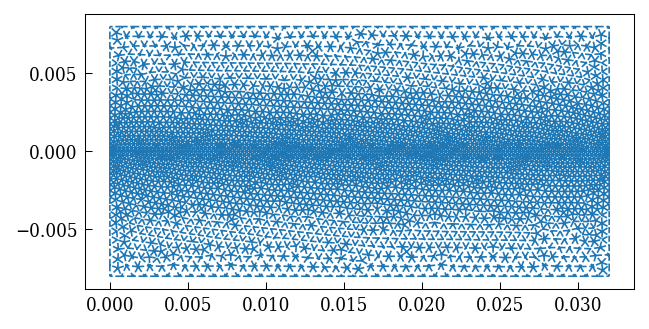

In [4]:
tuto.plotMesh(mesh)

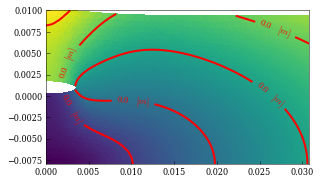

In [5]:
tuto.plotResult(model, displacement=model.getDisplacement(), field='displacement', contour=5)

### **Regularization of the problem with PhaseField model**

The PhaseField model in **Akantu** can be employed by invoking the `class PhaseFieldModel` which is a standalone model class. The constitutive behavior of PhaseField model is defined by `PhaseFields` which is analogous to `Materials`of `class SolidMechanicsModel`. 

#### **Setting up the PhaseField constitutive law**

In [6]:
material_file = """
material phasefield [
    name = virtual
    rho = 1180.    # density
    E   = 3.09e9    # young's modulus
    nu  = 0.35  # poisson's ratio
    finite_deformation = false
]

phasefield exponential [
  name = virtual
  E = 3.09e9
  nu = 0.35
  gc = 300.
  l0 = 1e-4
]

"""

with open('material.dat', 'w') as f:
    f.write(material_file)

There are two blocks in material file:
- material phasefield : defines the constitutive behavior of solid mechanics model (currently only for elastic materials)
- phasefield exponential : defines the constitutive beahvior of phasefield model (currently applicable only for exponential shape phasefield)

#### **Coupling Solid Mechanics Model and PhaseField Model**

`PhaseFieldModel` needs to be coupled with `SolidMechanicsModel` for solving fracture mechanics problem. The `SolidMechanicsModel` solve for the stresses and strains whereas `PhaseFieldModel` uses the strains to solve for the fracture represented by a damage parameter (0=no-damage and 1=completely damaged).  

In **Akantu**, coupler class called `CouplerSolidPhaseField` is provided which eases the coupling between the two models

#### **Setting up the _SolidMechanicsModel_ and _PhaseFieldModel_**

We need to read again the material file and the mesh

In [7]:
# reading material file
aka.parseInput('material.dat')
# creating mesh
spatial_dimension = 2
mesh = aka.Mesh(spatial_dimension)
mesh.read('plate.msh')

Then CouplerSolidPhaseModel is invoked which further by itself creates the instances of _SolidMechanicsModel_ and _PhaseFieldModel_.

In [8]:
model = aka.CouplerSolidPhaseField(mesh)

solid = model.getSolidMechanicsModel()
phase = model.getPhaseFieldModel()

# initializing the Solid Mechanics Model with implicit solver for static resolution
solid.initFull(_analysis_method=aka._static)
solver = solid.getNonLinearSolver('static')
solver.set('max_iterations', 100)
solver.set('threshold', 1e-10)
solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)

# adding another solver dynamic/quasi-static resolution (explicit Newmark with lumped mass) 
solid.initNewSolver(aka._explicit_lumped_mass)

# initializing the PhaseField Model with linear implicit solver for static resolution
phase.initFull(_analysis_method=aka._static)

# initializing the PhaseField Model with Newton Raphson implicit solver for static resolution
phase.getNewSolver("nonlinear_static", aka.TimeStepSolverType.static,
                    aka.NonLinearSolverType.newton_raphson)
phase.setIntegrationScheme("nonlinear_static", "damage",
                            aka.IntegrationSchemeType.pseudo_time)

solver = phase.getNonLinearSolver('nonlinear_static')
solver.set('max_iterations', 100)
solver.set('threshold', 1e-3)
solver.set("convergence_type", aka.SolveConvergenceCriteria.solution)

#### **Generate paraview files**

In [9]:
# Initialization for bulk vizualisation
solid.setBaseName('plate')
solid.addDumpFieldVector('displacement')
solid.addDumpFieldVector('external_force')
solid.addDumpFieldVector('velocity')
solid.addDumpField('strain')
solid.addDumpField('stress')
solid.addDumpField('damage')
solid.addDumpField('blocked_dofs')

#### **Setting the boundary condition**

The boundary conditions are applied on the _SolidMechanicsModel_

In [10]:
class FixedDisplacement(aka.DirichletFunctor):
    '''
        Fix the displacement at its current value
    '''
    def __init__(self, axis):
        super().__init__(axis)
        self.axis = axis

    def __call__(self, node, flags, disp, coord):
        # sets the blocked dofs vector to true in the desired axis
        flags[int(self.axis)] = True


class FixedDamage(aka.DirichletFunctor):
    '''
        Fix the damage to 0 
    '''
    def __init__(self, axis):
        super().__init__(axis)
        self.axis = axis

    def __call__(self, node, flags, dam, coord):
        # sets the blocked dofs vector to true in the desired axis
        flags[int(self.axis)] = True
        dam[int(self.axis)] = 0.0

In [11]:
# Dirichlet
solid.applyBC(aka.FixedValue(0., aka._x), 'top')
solid.applyBC(aka.FixedValue(0., aka._x), 'bottom')

solid.applyBC(aka.FixedValue(0., aka._x), 'left')
solid.applyBC(aka.FixedValue(0., aka._x), 'right')


solid.applyBC(aka.FixedValue(0.06e-3, aka._y), 'top')
solid.applyBC(aka.FixedValue(-0.06e-3, aka._y), 'bottom')

# Dirichlet Condition for damage in PhaseField model
#phase.applyBC(FixedDamage(aka._x), 'top')

#### **Static resolution**

The resolution of the regularized problem is made with 1000 explicit steps, during which the velocity is damped to dissipate kinetic energy and to reach static equilibrium. In this resolution, both _SolidMechanicsModel_ and _PhaseFieldModel_ are solved using the staggered scheme , where first solid mechanics model is solved. The strains thus computed are transferred to the _PhaseFieldModel_ and is then solved for. At the end, the damage computed from the Phasefield model is transferred back to the Solid mechanics model to degrade the stiffness/stresses. 

The above staggered scheme is implemented with the `CouplerSolidPhaseField` and can be employed by calling the function `solve`. The function `solve` takes an input argument which indicates the solver type(implicit or explicit) for the `SolidMechanicsModel`. For `PhaseFieldModel`, the solver type is alwas implicit type.

In [12]:
solid.solveStep('static')
solid.dump()

#### **Dynamic resolution**

In [13]:
 # choose the timestep
solid.setTimeStep(solid.getStableTimeStep()*0.1)

edis = []
epot = []
ekin = []

# set maximum number of iteration
maxsteps = 5000
# solve
for i in tqdm(range(0, maxsteps)):
    model.solve('explicit_lumped', 'static')
    if i % 100 == 0:
        model.dump()
    edis.append(solid.getEnergy('dissipated'))
    ekin.append(solid.getEnergy('kinetic'))
    epot.append(solid.getEnergy('potenital'))
    

  0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
mesh = solid.getMesh()
conn = mesh.getConnectivity(aka._triangle_3)
nodes = mesh.getNodes()

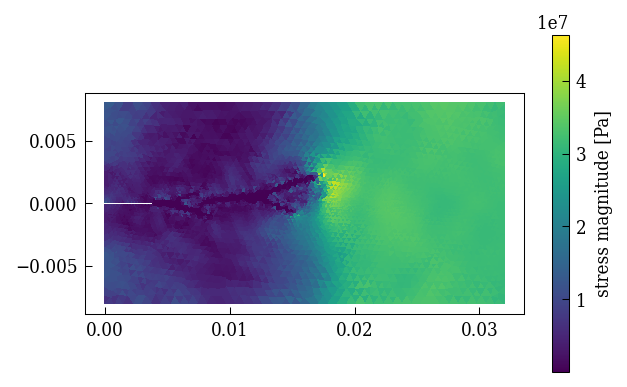

In [15]:
plt.axes().set_aspect('equal')
# plot the stress field on mesh with magnified displacements
u = solid.getDisplacement()
magnified_triangles = tri.Triangulation(nodes[:, 0]+u[:,0], nodes[:, 1]+u[:,1], conn)
stress_field = solid.getMaterial(0).getStress(aka._triangle_3)
stress_disp = plt.tripcolor(magnified_triangles, np.linalg.norm(stress_field, axis=1))
cbar = plt.colorbar(stress_disp)
cbar.set_label('stress magnitude [Pa]')

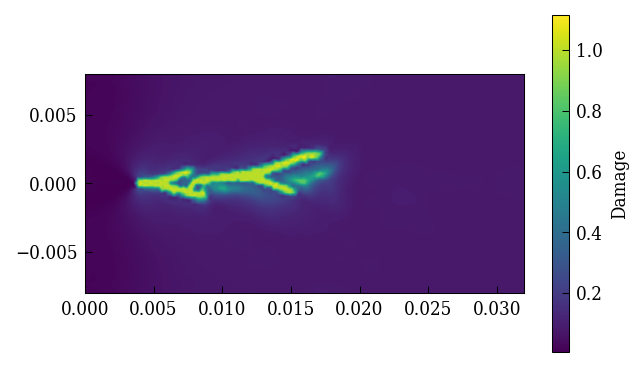

In [16]:
from scipy.interpolate import griddata
x =  np.linspace(0, 32e-3, num=400)
y = np.linspace(-8e-3, 8e-3, num=200)
xx, yy = np.meshgrid(x, y)

grid_z1 = griddata(nodes, phase.getDamage(), (xx, yy), method='linear')
plt.imshow(grid_z1, origin='lower', extent=[np.min(x), np.max(x), np.min(y), np.max(y)])
plt.colorbar(label='Damage')
plt.show()

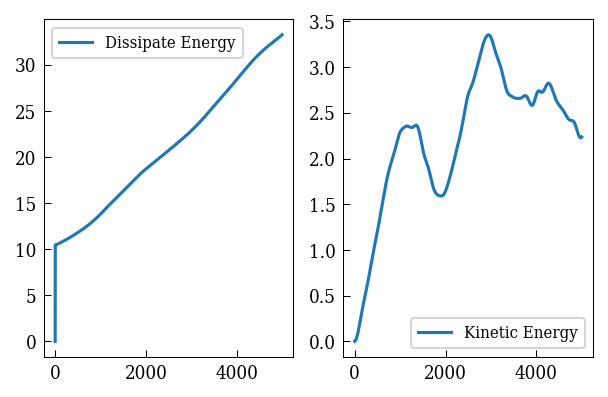

In [17]:
fig, axe = plt.subplots(1, 2)
axe[0].plot(edis, label='Dissipate Energy')
axe[1].plot(ekin, label='Kinetic Energy')
axe[0].legend()
axe[1].legend()
plt.show()